# Fully learned reconstruction

In the following exercise we will train a notebook for solving the directly the Inverse Problem
$$\varphi_\Theta: Y \to X$$

Given $N$ training pairs $S = \{(y^\delta_i, x^\dagger_i)\}$ we will train the network by minimizing the loss function 

$$L_S(\Theta) = \sum_{i=1}^N \Vert \varphi_\Theta(y^\delta_i) - x_i^\dagger \Vert$$

## Load the data

In [0]:
import numpy as np
from skimage.transform import radon, iradon

n, m = 28, 28

###############################################
# TODO: Set number of angles
angles = 5
###############################################

detectors = 40

theta = np.linspace(0.0, 180.0, angles, endpoint=False)

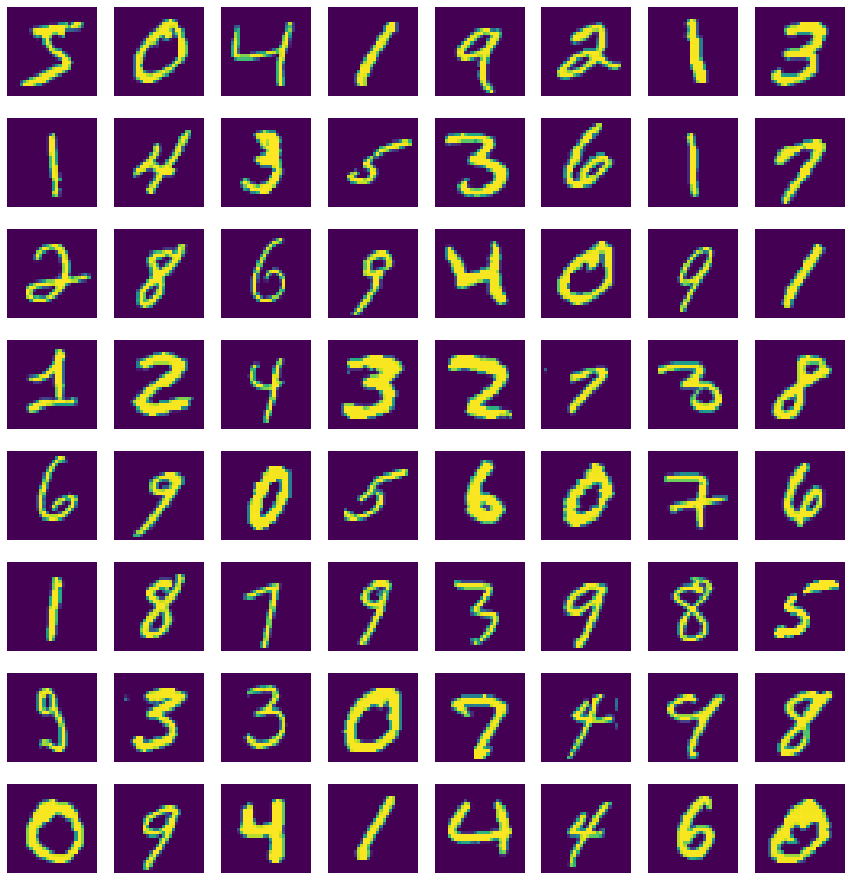

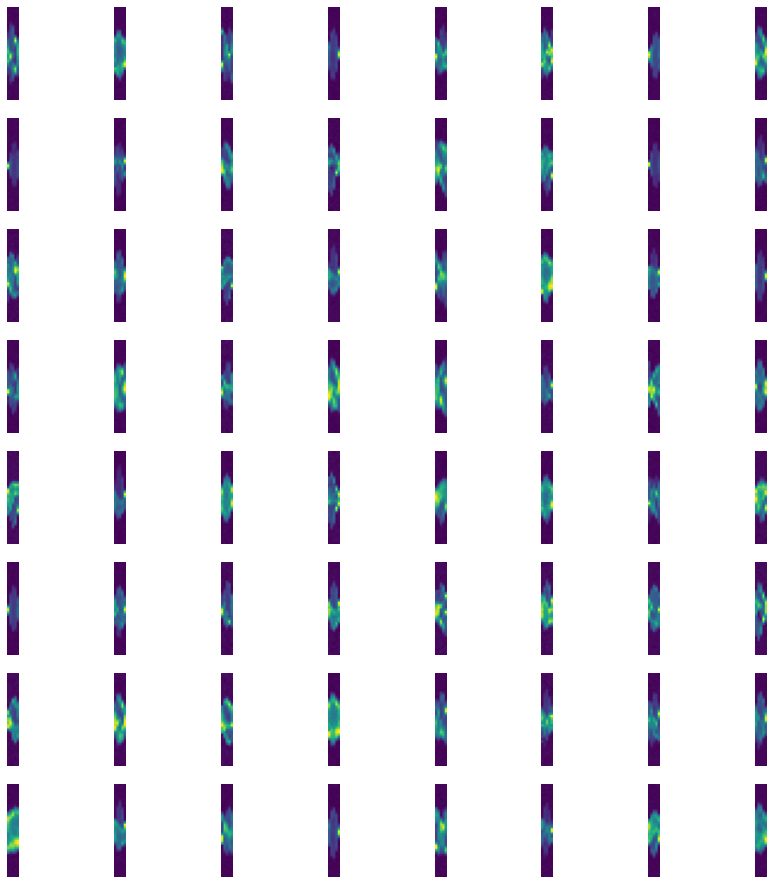

In [5]:
import torch

import matplotlib.pyplot as plt

from torchvision import datasets, transforms
from torch.utils.data import Dataset

batch_size = 64

transform_train = transforms.Compose([
    transforms.ToTensor()
])

transform_test = transforms.Compose([
    transforms.ToTensor()
])


def forward(phantom):
    sinogram = radon(np.array(phantom).squeeze(), theta, circle=False)
    sinogram += 0.1 * np.random.normal(size=sinogram.shape)
    return sinogram


class SinogramData(Dataset):
    def __init__(self, dataset, forward):
        super(SinogramData, self).__init__()
        self.dataset = dataset

        self.sinograms = []
        for i in range(len(self.dataset)):
            x = self.dataset[i][0]
            self.sinograms.append(torch.tensor(forward(x), dtype=torch.float32))
        self.forward = forward
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        x, _ = self.dataset[idx]
        y = self.sinograms[idx]
        return x, y
    
# datasets (MNIST)
mnist_train = SinogramData(datasets.MNIST('/data', train=True, download=True, transform=transform_train), forward)
mnist_test  = SinogramData(datasets.MNIST('/data', train=False, download=True, transform=transform_test), forward)

# dataloaders
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size)


def visualize_batch(batch, ncols=8):
    nrows = (batch.shape[0] + ncols - 1) // ncols
    plt.figure(figsize=(15, 2 * nrows))
    for i in range(batch.shape[0]):
        plt.subplot(nrows, ncols, i+1)
        plt.imshow(batch[i].squeeze())
        plt.axis('off')
    plt.show()


x_batch, y_batch = next(iter(train_loader))
visualize_batch(x_batch)
visualize_batch(y_batch)

## Create the neural network

In [22]:
import torch.nn as nn
import torch.nn.functional as F

###############################################
# TODO1: Create a network with only one linear layer (as in the regression example)
# TODO2: Add more layers (after running the first time)
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()    
        self.channels = 10
        self.conv1 = nn.Conv2d(1, self.channels, kernel_size=3, stride=1, padding=1) 
        self.conv2 = nn.Conv2d(self.channels, self.channels, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(self.channels, self.channels, kernel_size=3, stride=1, padding=1)
        self.lin = nn.Linear(self.channels * angles * detectors, n * m)
        
    def forward(self, x):
        x = x.view(-1, 1, detectors, angles)
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = x.view(-1, self.channels * angles * detectors)
        x = self.lin(x)
        return x.view(-1, 1, n, m)
###############################################

model = Net()
print(model)

Net(
  (conv1): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (lin): Linear(in_features=2000, out_features=784, bias=True)
)


## Set the hyperparameters, the loss function and the optimizer

In [24]:
# learning rate
lr = 0.001

# number of epochs
n_epochs = 20

###############################################
# TODO: Choose the loss function
loss_function = nn.MSELoss()
###############################################


###############################################
# TODO: Choose the optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = lr)
###############################################

# set device to use
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cuda


## Train the network

In [25]:
from skimage.measure import compare_psnr

model.to(device)

# iterate over epochs
for i in range(n_epochs):
  
    train_loss = 0.0
    test_loss = 0.0

    model.train()
    # iterate over batches
    for j, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        
        ######################################################
        # TODO: Compute the output and do the backprop
        # 1) zero the gradients
        # 2) compute the output of the model
        # 3) compute the loss function
        # 4) backpropagate
        # 5) do a gradient step
        
        optimizer.zero_grad()
        loss = loss_function(model(y), x)
        loss.backward()
        optimizer.step()

        ######################################################

        train_loss += loss.item() * x.shape[0]
        if j % 200 == 0:
            print('%d/%d' % (j, len(train_loader)))
      
    
    model.eval()
    with torch.set_grad_enabled(False):
        # iterate on batches
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            
            ######################################################
            # TODO: Evaluate the performance of the current parameters
            # 1) compute the output of the network
            # 2) compute the loss function
            loss = loss_function(model(y), x)
            ######################################################

            test_loss += loss.item() * x.shape[0]

    train_loss /= len(mnist_train)
    test_loss /= len(mnist_test)

    print('epoch: %d train-error: %.5f test-error: %.4f' % (i, train_loss, test_loss))

0/938
200/938
400/938
600/938
800/938
epoch: 0 train-error: 0.01655 test-error: 0.0119
0/938
200/938
400/938
600/938
800/938
epoch: 1 train-error: 0.01017 test-error: 0.0102
0/938
200/938
400/938
600/938
800/938
epoch: 2 train-error: 0.00929 test-error: 0.0096
0/938
200/938
400/938
600/938
800/938
epoch: 3 train-error: 0.00887 test-error: 0.0094
0/938
200/938
400/938
600/938
800/938
epoch: 4 train-error: 0.00861 test-error: 0.0093
0/938
200/938
400/938
600/938
800/938
epoch: 5 train-error: 0.00843 test-error: 0.0091
0/938
200/938
400/938
600/938
800/938
epoch: 6 train-error: 0.00829 test-error: 0.0089
0/938
200/938
400/938
600/938
800/938
epoch: 7 train-error: 0.00818 test-error: 0.0088
0/938
200/938
400/938
600/938
800/938
epoch: 8 train-error: 0.00809 test-error: 0.0088
0/938
200/938
400/938
600/938
800/938
epoch: 9 train-error: 0.00801 test-error: 0.0086
0/938
200/938
400/938
600/938
800/938
epoch: 10 train-error: 0.00794 test-error: 0.0085
0/938
200/938
400/938
600/938
800/938
epoc

## Evaluate the average performance (PSNR)

In [26]:
def PSNR(imtrue, imother):
    return compare_psnr(imtrue, imother, data_range=imtrue.max()-imtrue.min())

model.eval()
# iterate on batches

psnr = 0
for x, y in test_loader:
    x, y = x.to(device), y.to(device)
    outputs = model(y)
    
    for j in range(x.shape[0]):
        psnr += PSNR(x[j].cpu().numpy(), outputs[j].detach().cpu().numpy())
        
psnr /= len(mnist_test)
print(psnr)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


21.445737493912073


## Show some examples

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: UserWarning: DEPRECATED: skimage.measure.compare_psnr has been moved to skimage.metrics.peak_signal_noise_ratio. It will be removed from skimage.measure in version 0.18.
  


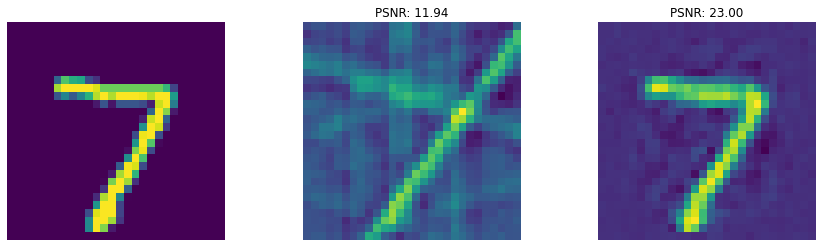

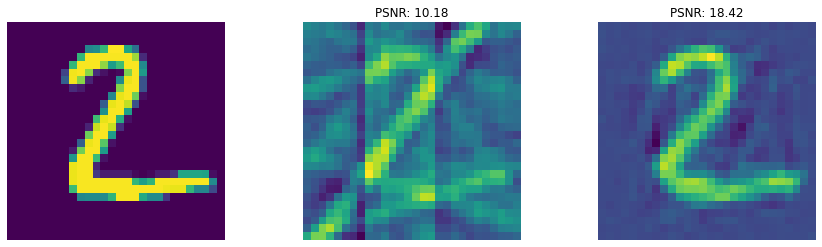

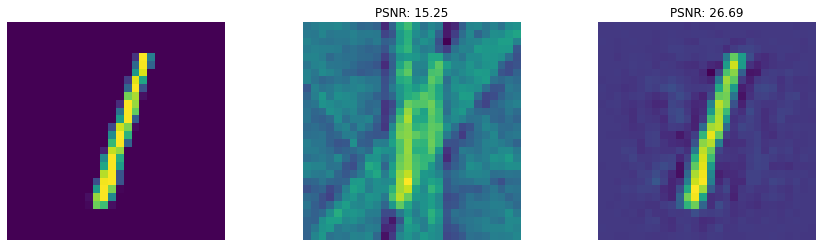

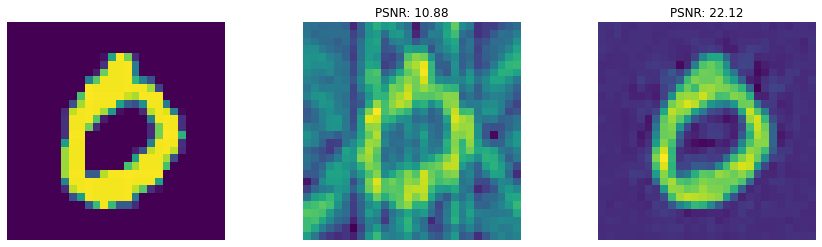

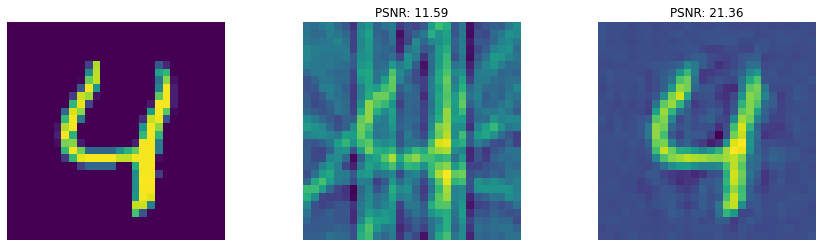

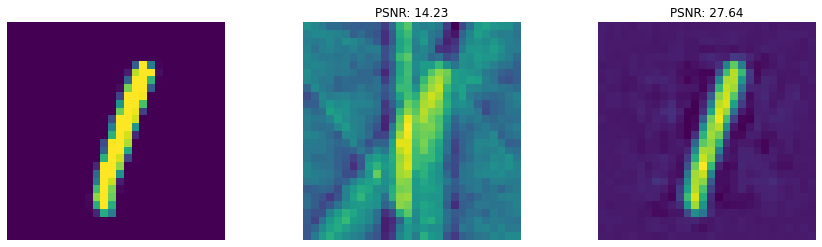

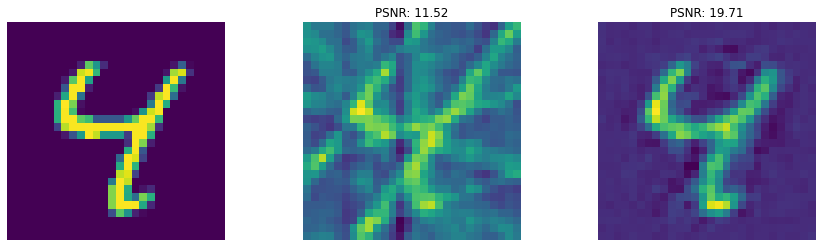

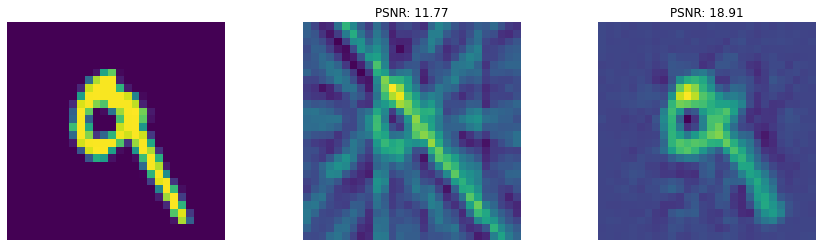

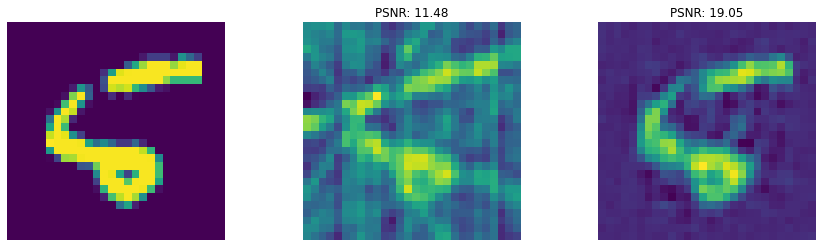

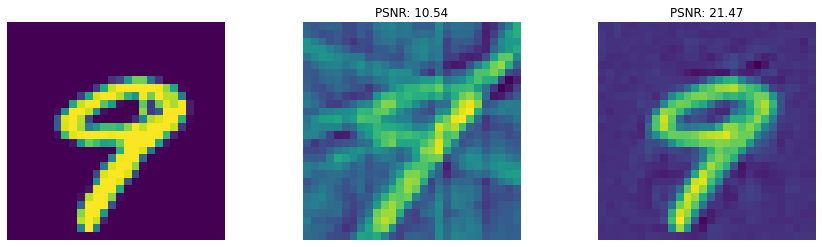

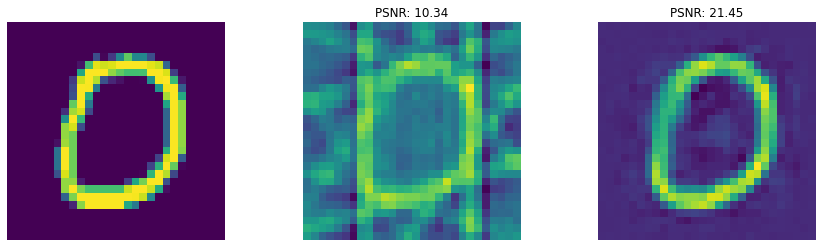

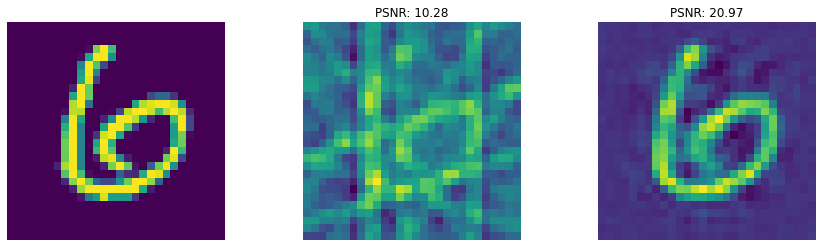

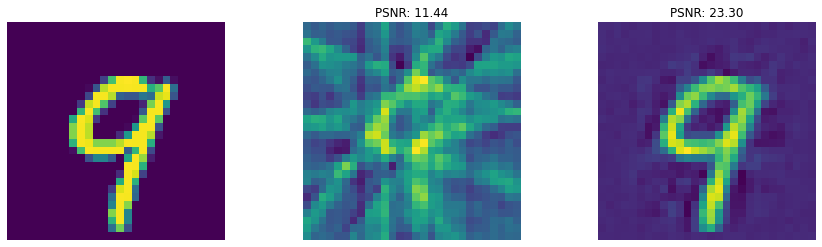

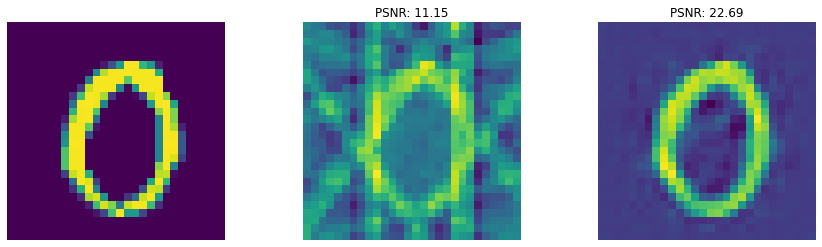

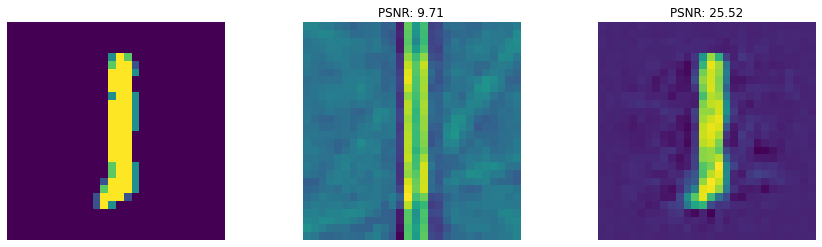

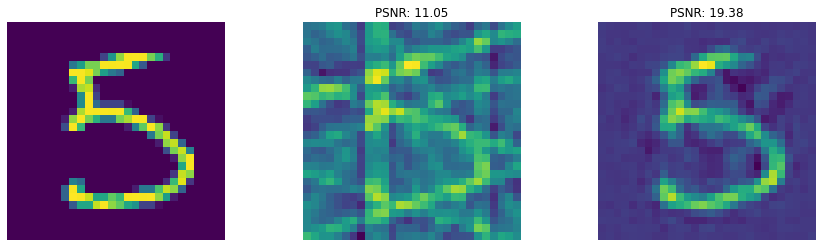

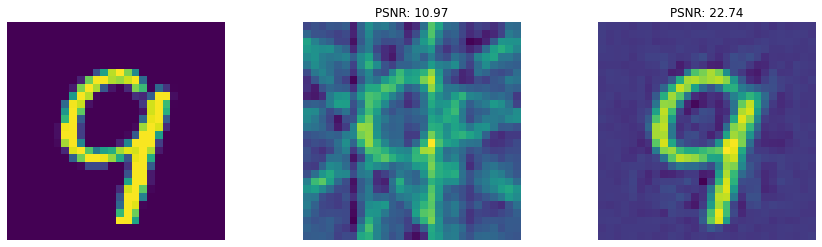

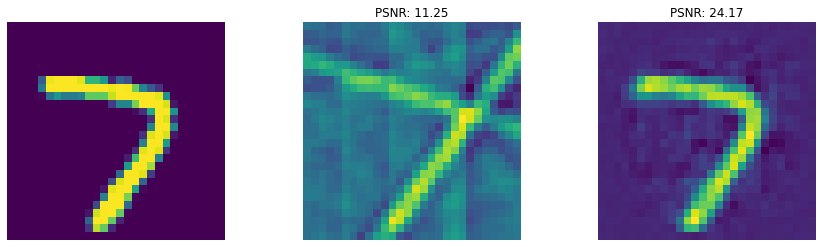

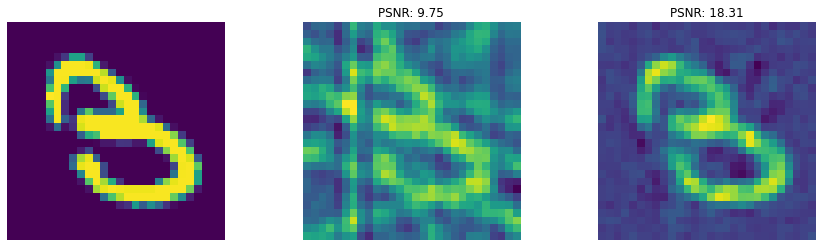

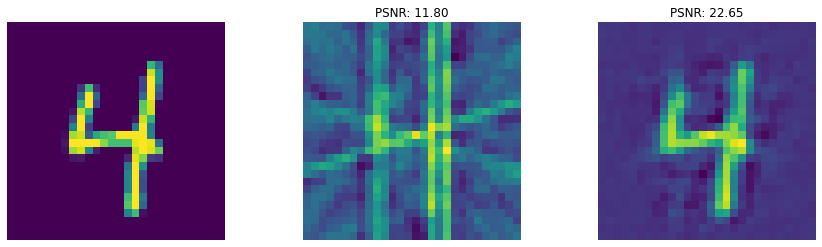

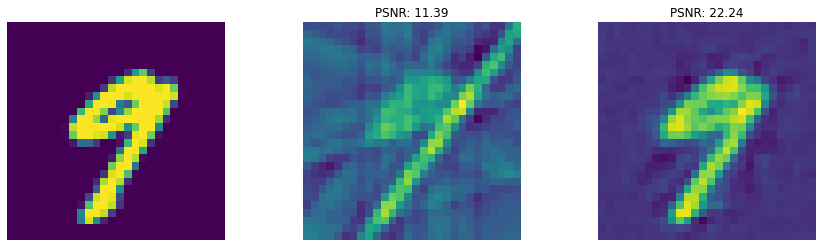

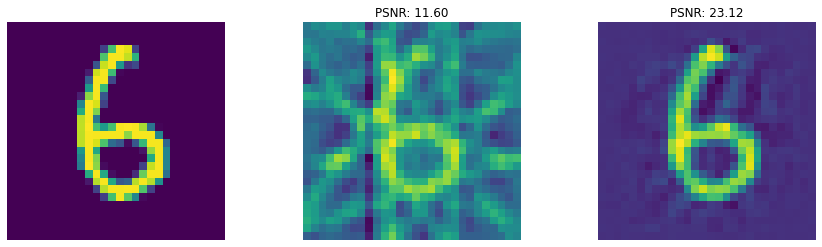

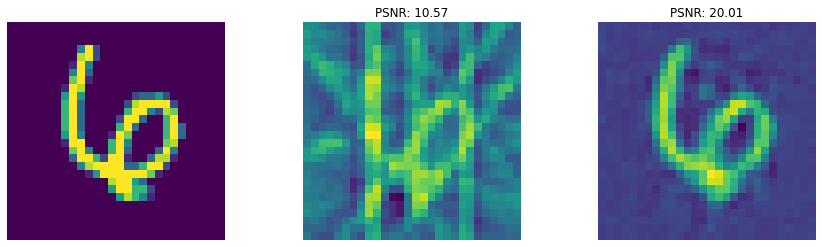

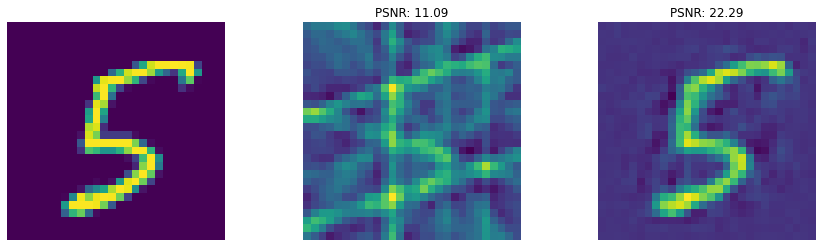

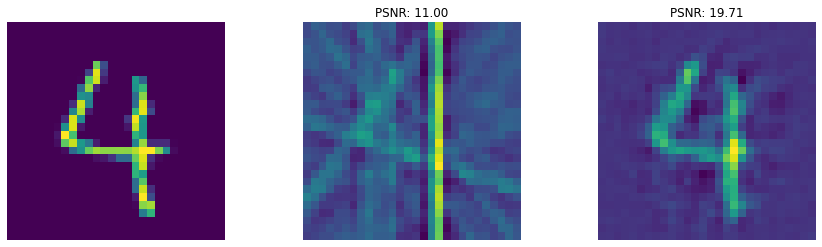

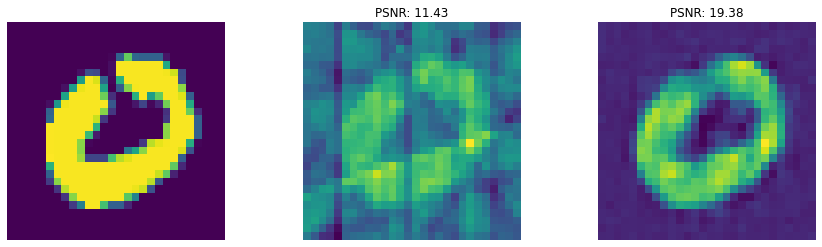

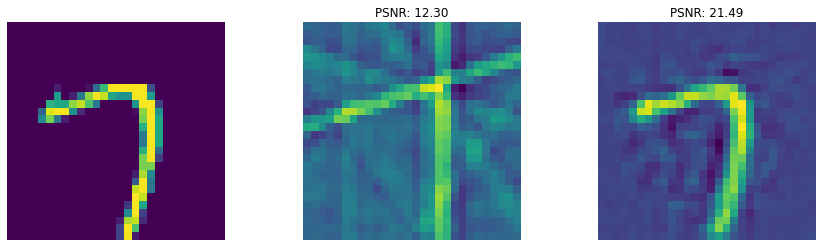

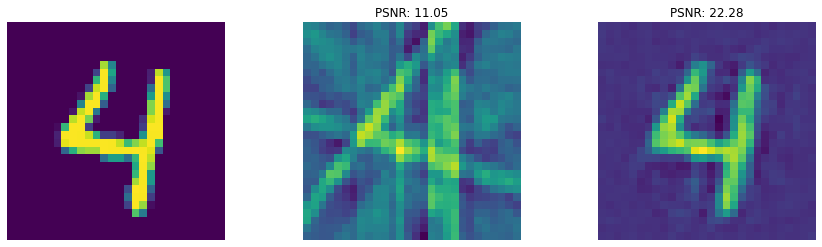

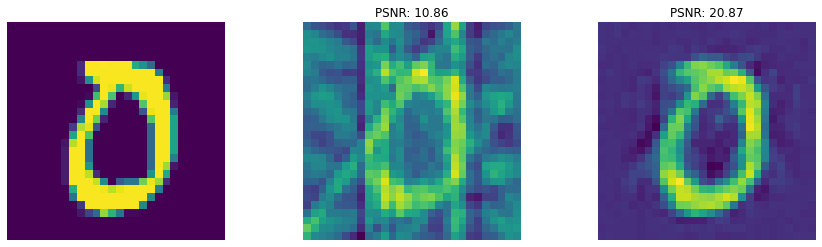

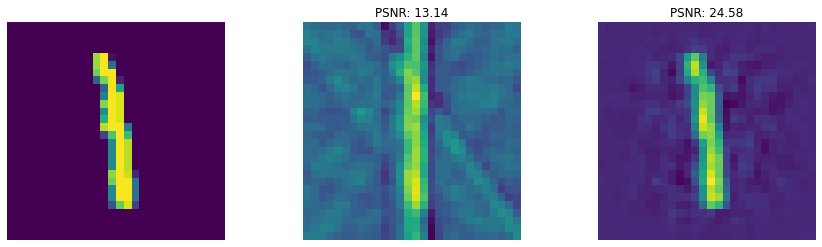

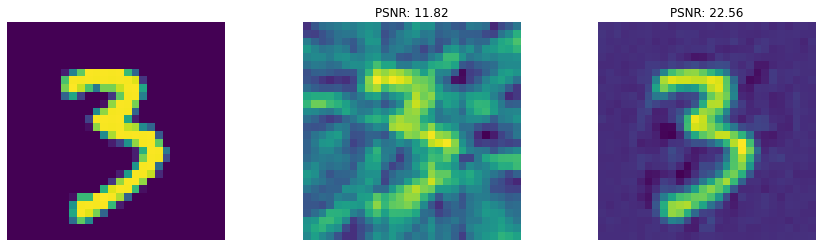

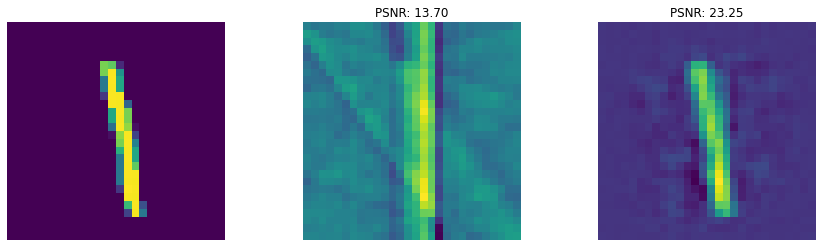

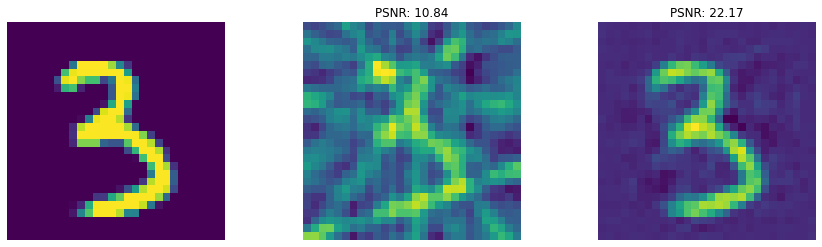

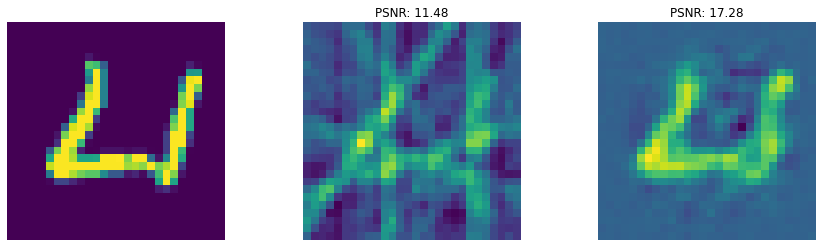

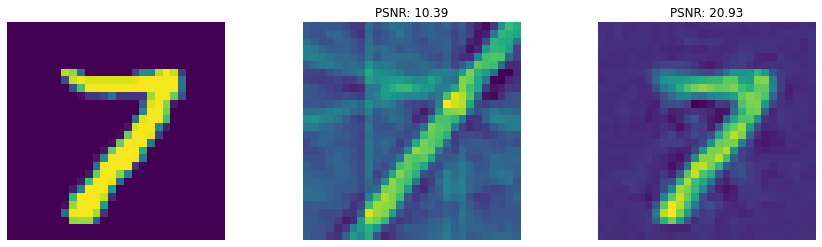

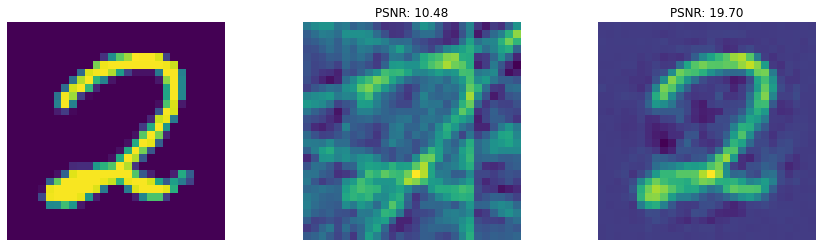

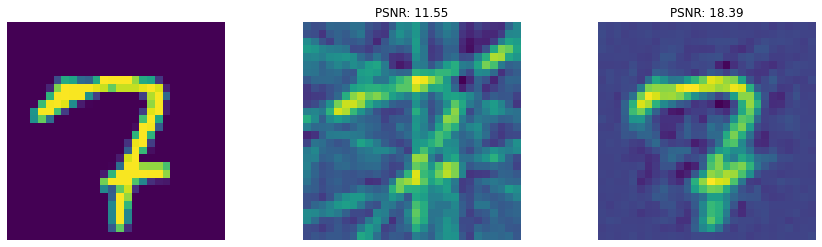

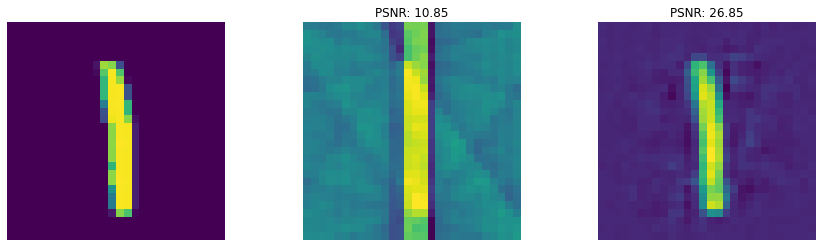

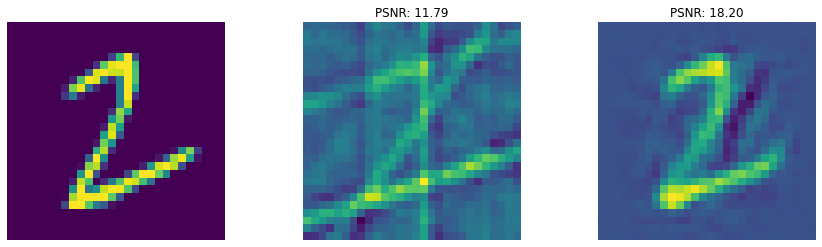

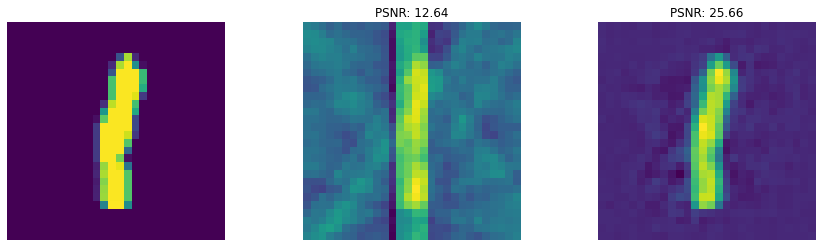

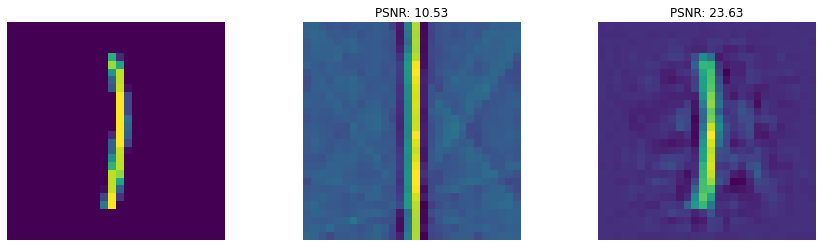

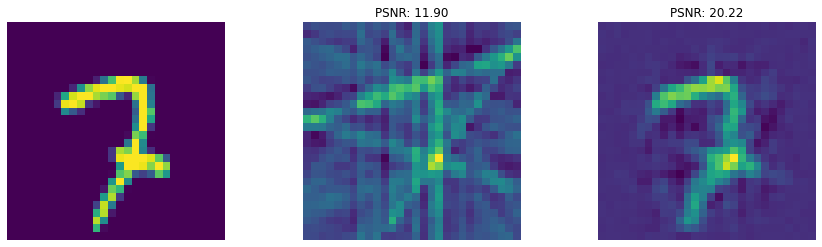

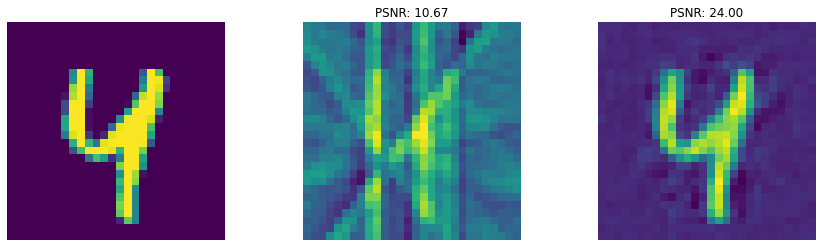

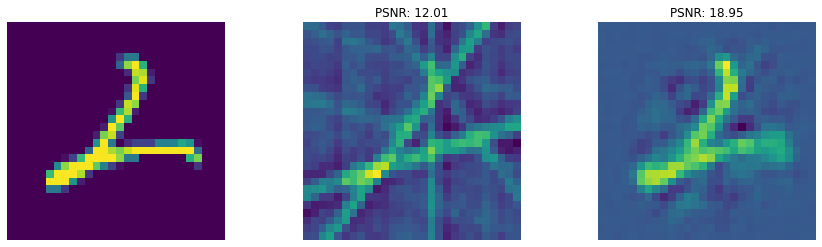

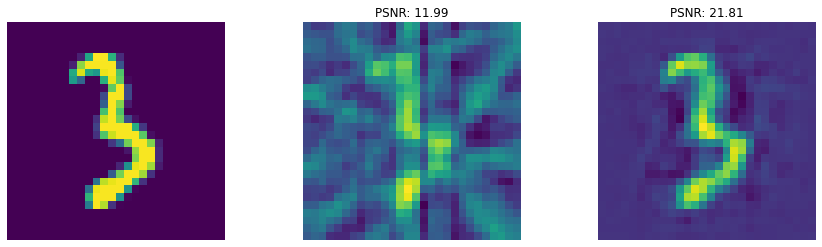

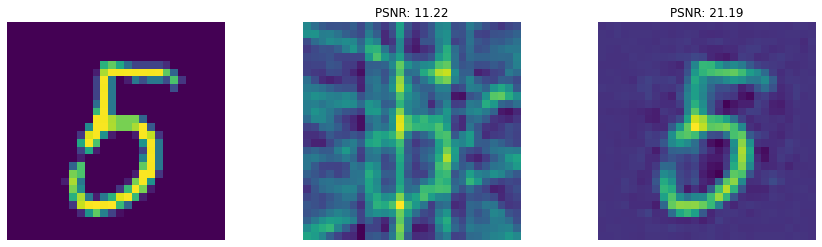

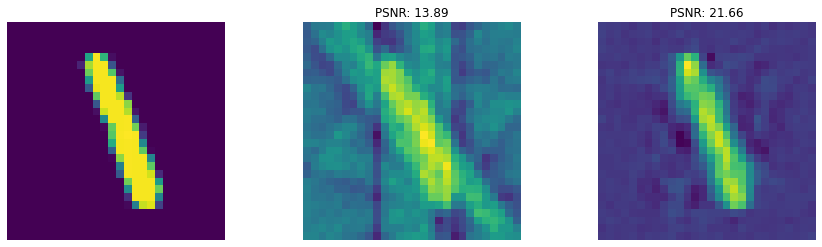

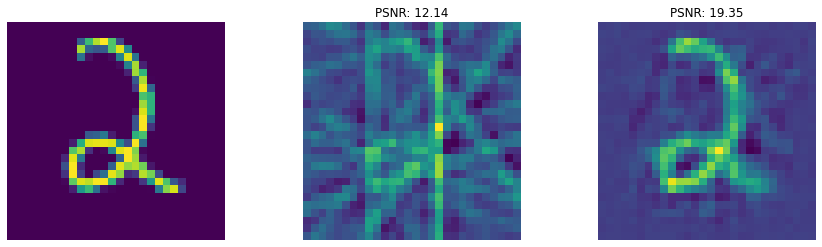

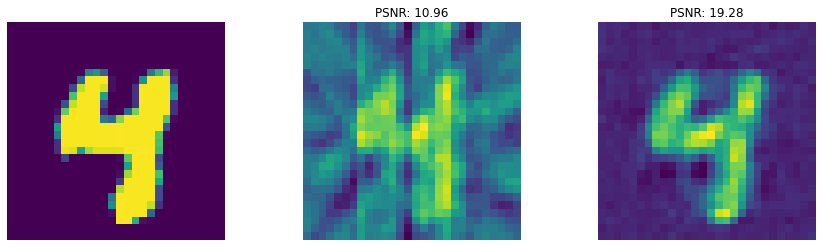

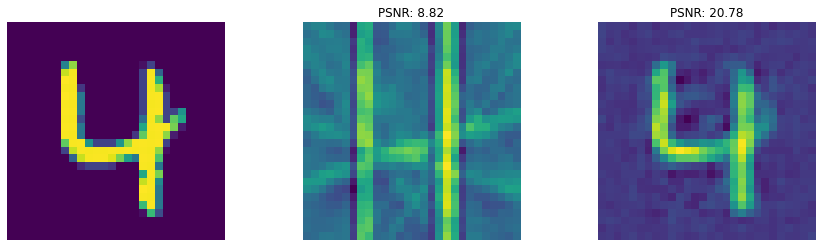

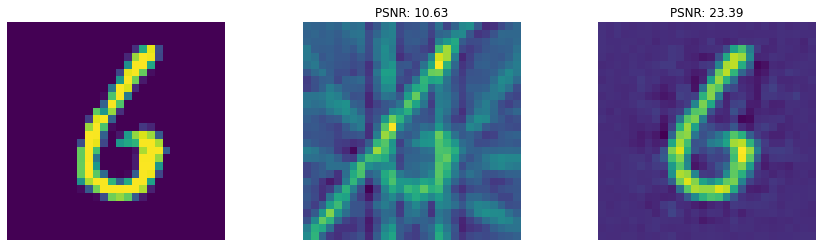

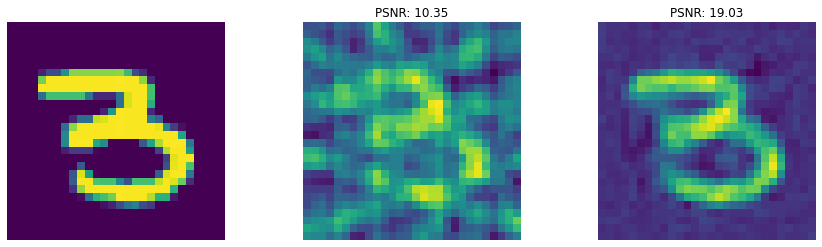

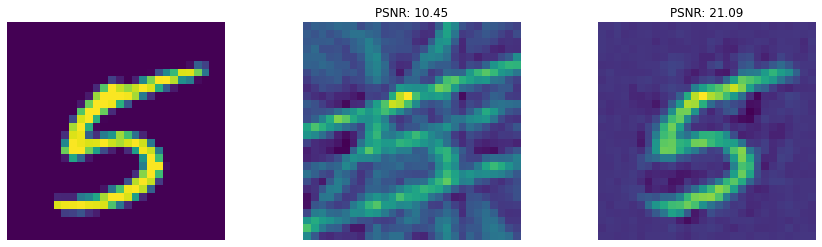

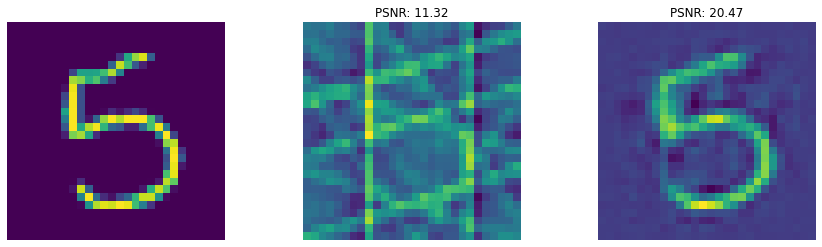

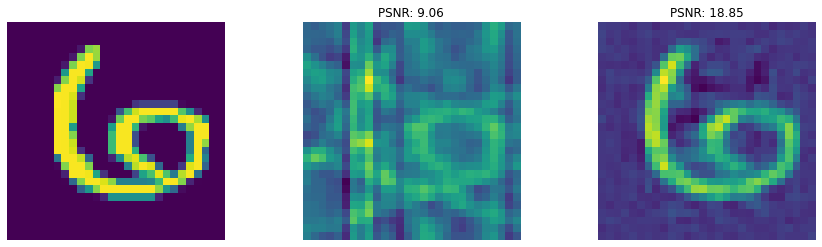

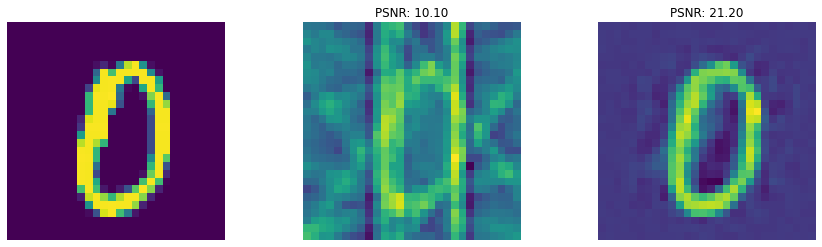

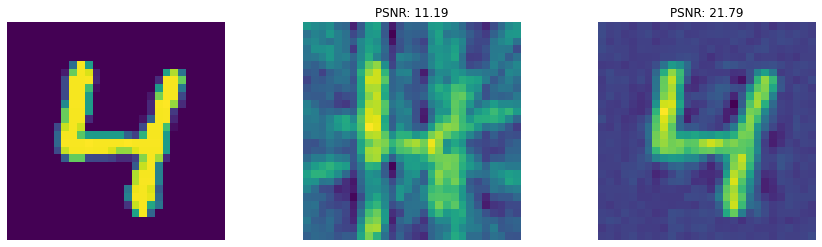

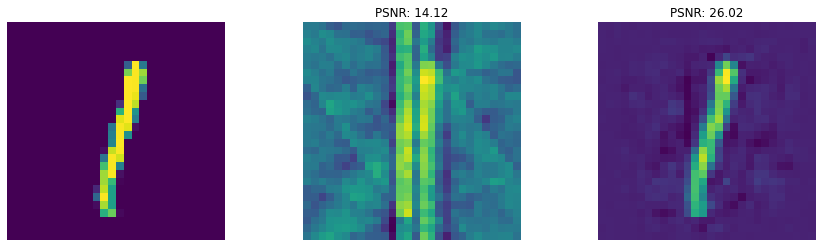

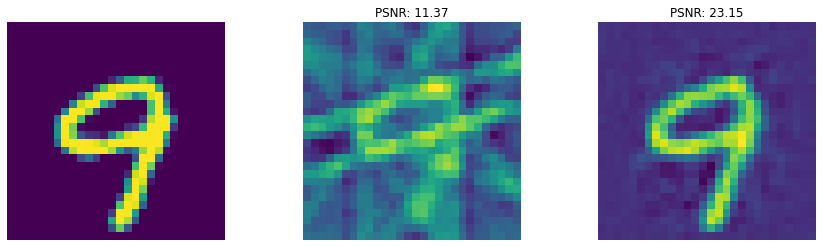

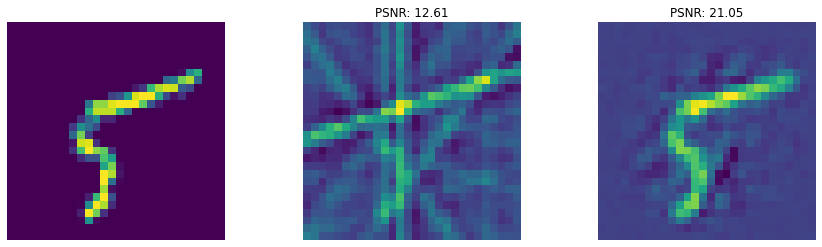

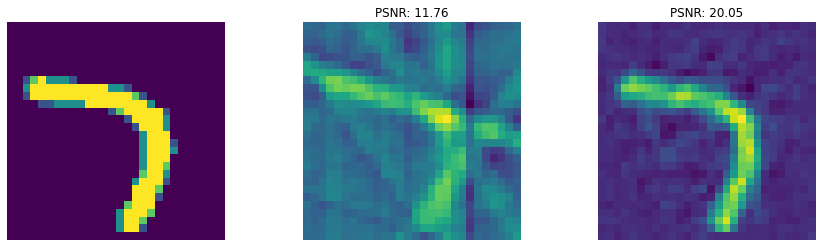

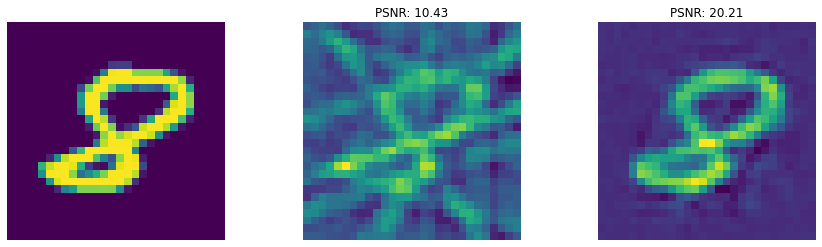

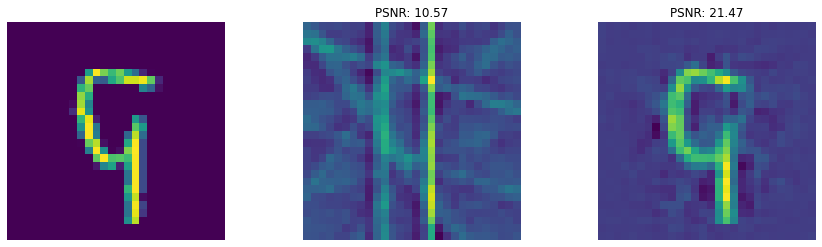

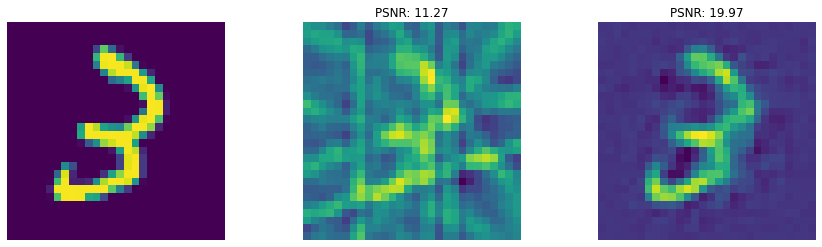

In [27]:
import torch.nn.functional as F
from skimage.transform import iradon


model.to(device)
model.eval()

# first batch of data pairs
x, y = next(iter(test_loader))

########################################################
# TODO compute the output of the network
outputs = model(y.to(device)).detach()
########################################################

for i in range(x.shape[0]):
    plt.figure(figsize=(15, 4))
   
    plt.subplot(1,3,1)
    
    plt.imshow(x[i].squeeze())
    plt.axis('off')
    
    plt.subplot(1,3,2)
    
    x_rec = iradon(y[i].cpu().numpy(), theta, circle=False)
    plt.imshow(x_rec)
    psnr1 = PSNR(x[i][0].cpu().numpy(), x_rec)
    
    plt.title('PSNR: %.2f' % psnr1)
    plt.axis('off')

    plt.subplot(1,3,3)
    psnr2 = PSNR(x[i].cpu().numpy(), outputs[i].detach().cpu().numpy())
    plt.title('PSNR: %.2f' % psnr2)
    
    plt.imshow(outputs[i].detach().cpu().numpy().squeeze())
    plt.axis('off')
    
    plt.show()